In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler


2025-06-27 16:23:53.567314: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751041433.748984      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751041433.807409      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load Data
df = pd.read_csv("/kaggle/input/stock-market-dataset/stocks/AAPL.csv")

In [3]:
df['Date'] = pd.to_datetime(df['Date'])

In [19]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
1980-12-12,0.513393,0.515625,0.513393,0.513393,117258400
1980-12-15,0.488839,0.488839,0.486607,0.486607,43971200
1980-12-16,0.453125,0.453125,0.450893,0.450893,26432000
1980-12-17,0.462054,0.464286,0.462054,0.462054,21610400
1980-12-18,0.475446,0.477679,0.475446,0.475446,18362400


In [4]:
df = df.set_index('Date')

In [5]:
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

In [20]:
df.head(10)

,Open,High,Low,Close,Volume
Date,,,,,
1980-12-12,0.513393,0.515625,0.513393,0.513393,117258400
1980-12-15,0.488839,0.488839,0.486607,0.486607,43971200
1980-12-16,0.453125,0.453125,0.450893,0.450893,26432000
1980-12-17,0.462054,0.464286,0.462054,0.462054,21610400
1980-12-18,0.475446,0.477679,0.475446,0.475446,18362400
1980-12-19,0.504464,0.506696,0.504464,0.504464,12157600
1980-12-22,0.529018,0.531250,0.529018,0.529018,9340800
1980-12-23,0.551339,0.553571,0.551339,0.551339,11737600
1980-12-24,0.580357,0.582589,0.580357,0.580357,12000800


In [6]:
# Scale all features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_data, index=df.index, columns=df.columns)

In [7]:
# Create sequences (windowed data)
def create_multivariate_sequences(df, target_col='Close', window=60):
    X, y, dates = [], [], []
    for i in range(window, len(df)):
        X.append(df.iloc[i-window:i].values)  # past `window` days of all features
        y.append(df.iloc[i][target_col])      # only the scaled 'Close' value
        dates.append(df.index[i])
    return np.array(X), np.array(y), np.array(dates)

In [8]:
X, y, dates = create_multivariate_sequences(scaled_df, target_col='Close', window=60)

In [9]:
# Split data chronologically
split_80 = int(len(X) * 0.8)
split_90 = int(len(X) * 0.9)

In [10]:
X_train, y_train, dates_train = X[:split_80], y[:split_80], dates[:split_80]
X_val, y_val, dates_val = X[split_80:split_90], y[split_80:split_90], dates[split_80:split_90]
X_test, y_test, dates_test = X[split_90:], y[split_90:], dates[split_90:]


In [11]:
# Build LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.summary()

I0000 00:00:1751041521.964403      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 64)              │          17,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,369 (118.63 KB)

 Trainable params: 30,369 (118.63 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Train model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

Epoch 1/10


I0000 00:00:1751041532.781138     110 cuda_dnn.cc:529] Loaded cuDNN version 90300


247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 2.0726e-04 - val_loss: 1.4434e-04
Epoch 2/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7.6102e-06 - val_loss: 2.1323e-04
Epoch 3/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7.8927e-06 - val_loss: 9.8195e-05
Epoch 4/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.5905e-06 - val_loss: 1.3840e-04
Epoch 5/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5.0866e-06 - val_loss: 1.2811e-04
Epoch 6/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4.7526e-06 - val_loss: 1.0154e-04
Epoch 7/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5.1813e-06 - val_loss: 7.1272e-05
Epoch 8/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4.8322e-06 - val_loss: 6.8091e-05
Epoch 9/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4.2137e-06 - val_loss: 6.0423e-05
Epoch 10/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5.6265e-06 - val_loss: 5.6117e-05


In [13]:
# Predict
y_train_pred = model.predict(X_train)
y_val_pred   = model.predict(X_val)
y_test_pred  = model.predict(X_test)


247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [14]:
# Inverse transform only the 'Close' value
close_scaler = MinMaxScaler()
close_scaler.min_, close_scaler.scale_ = scaler.min_[3], scaler.scale_[3]
y_train_inv = close_scaler.inverse_transform(y_train_pred).flatten()
y_val_inv   = close_scaler.inverse_transform(y_val_pred).flatten()
y_test_inv  = close_scaler.inverse_transform(y_test_pred).flatten()

In [15]:
y_train_orig = close_scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_val_orig   = close_scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
y_test_orig  = close_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

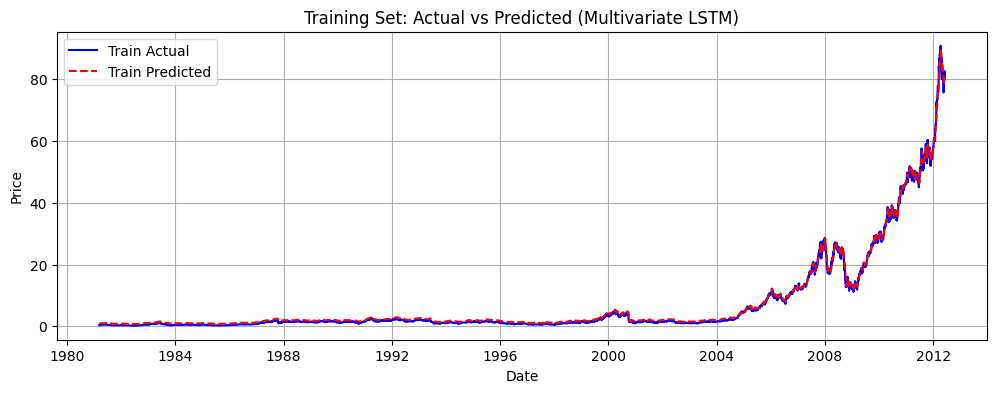

In [16]:
# Plot: Train
plt.figure(figsize=(12, 4))
plt.plot(dates_train, y_train_orig, label='Train Actual', color='blue')
plt.plot(dates_train, y_train_inv, '--', label='Train Predicted', color='red')
plt.title("Training Set: Actual vs Predicted (Multivariate LSTM)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


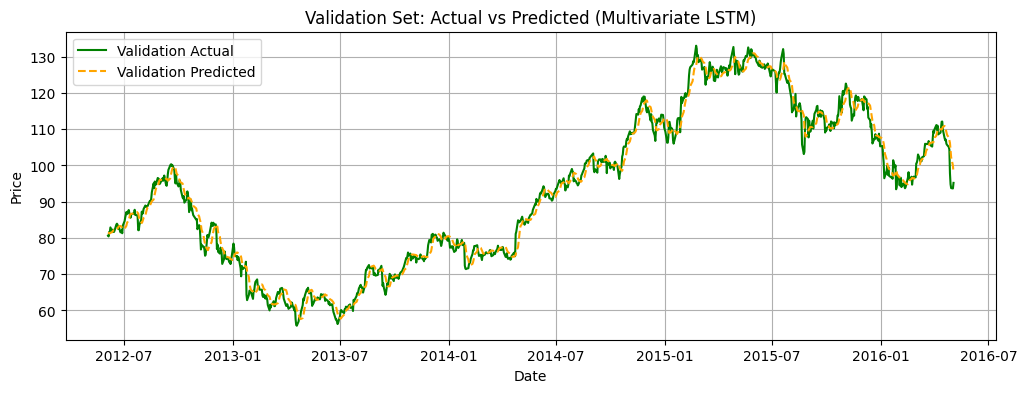

In [17]:
# Plot: Validation
plt.figure(figsize=(12, 4))
plt.plot(dates_val, y_val_orig, label='Validation Actual', color='green')
plt.plot(dates_val, y_val_inv, '--', label='Validation Predicted', color='orange')
plt.title("Validation Set: Actual vs Predicted (Multivariate LSTM)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


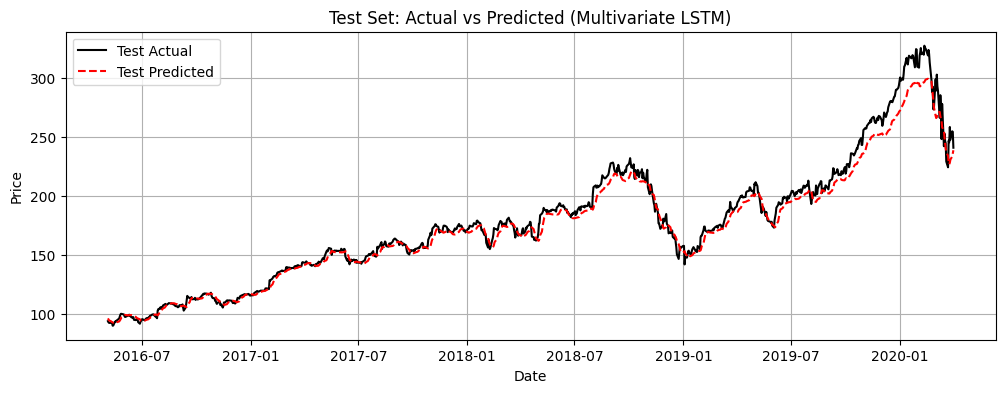

In [18]:
# Plot: Test
plt.figure(figsize=(12, 4))
plt.plot(dates_test, y_test_orig, label='Test Actual', color='black')
plt.plot(dates_test, y_test_inv, '--', label='Test Predicted', color='red')
plt.title("Test Set: Actual vs Predicted (Multivariate LSTM)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()